## Overview

Notebook workspace for PlaneSpotSlicer.

Prerequisites:

* install scvis using this package: https://github.com/shahcompbio/scvis

In [1]:
from typing import Union

import meerkat as mk
import numpy as np
import torch
import torch.optim as optim
from torch.nn.functional import cross_entropy
from tqdm import tqdm

from domino.utils import unpack_args

from abstract import Slicer
from sklearn import mixture

In [2]:
from planespot import PlaneSpotSlicer

## Demo

(copied from `examples/01_intro.ipynb`)

In [3]:
import os

dp = mk.datasets.get("imagenette")

# we'll only be using the validation data
dp = dp.lz[dp["split"] == "valid"]

In [4]:
import torch
from torchvision.models import resnet18
import torchvision.transforms as transforms
model = resnet18(pretrained=True)

In [5]:
# 1. Define transform
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]),
])

# 2. Create new column with transform 
dp["input"] = dp["img"].to_lambda(transform)

# 1. Move the model to device
DEVICE = 'cpu'
model.to(DEVICE).eval()

# 2. Define a function that runs a forward pass over a batch 
@torch.no_grad()
def predict(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(DEVICE)  # We get the underlying torch tensor with `data` and move to GPU 
    out: torch.Tensor = model(x)  # Run forward pass

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "pred": out.cpu().numpy().argmax(axis=-1),
        "probs": torch.softmax(out, axis=-1).cpu().numpy(),
    }

# 3. Apply the update. Note that the `predict` function operates on batches, so we set 
# `is_batched_fn=True`. Also, the `predict` function only accesses the "input" column, by 
# specifying that here we instruct update to only load that one column and skip others 
dp = dp.update(
    function=predict,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

  0%|          | 0/123 [00:00<?, ?it/s]

In [6]:
import hashlib

import hashlib
x = "helo"
int.from_bytes(hashlib.sha256(x.encode('utf-8')).digest(), 'big') % 100

dp["correct"] = dp["pred"] == mk.NumpyArrayColumn(dp["label_idx"])
accuracy = dp["correct"].mean()
print(f"Micro accuracy across the ten Imagenette classes: {accuracy:0.3}")

Micro accuracy across the ten Imagenette classes: 0.672


In [7]:
# Choose a single ImageNet class

In [8]:
LABEL_IDX = 482

# convert to a binary task 
dp["prob"] = dp["probs"][:, LABEL_IDX]
dp["target"] = (dp["label_idx"] == LABEL_IDX)

# Drop rows that do not have the label
dp = dp[dp['target']]

## 1. Embed

In [9]:
from domino import embed

In [10]:
class Features:
    def __init__(self, requires_grad = None):
        self.features = None
        self.requires_grad = requires_grad
        
    def __call__(self, modules, module_in, module_out):
        if self.requires_grad is not None:
            module_out.requires_grad = self.requires_grad
        self.features = module_out
        
# Register feature hook
feature_hook = Features()
handle = list(model.modules())[66].register_forward_hook(feature_hook)

In [11]:
# Extract the last-layer embeddings from the model, and add them as the "embedding" column.

def last_layer(batch: mk.DataPanel):
    input_col: mk.TensorColumn = batch["input"] 
    x: torch.Tensor = input_col.data.to(DEVICE)  # We get the underlying torch tensor with `data` and move to GPU 
    
    ## add a hook to the model
    out: torch.Tensor = model(x)  # Run forward pass
    features: np.ndarray = feature_hook.features.data.cpu().numpy()

    # Return a dictionary with one key for each of the new columns. Each value in the
    # dictionary should have the same length as the batch. 
    return {
        "embedding": features
    }


In [12]:
dp = dp.update(
    function=last_layer,
    is_batched_fn=True,
    batch_size=32,
    input_columns=["input"], 
    pbar=True
)

  0%|          | 0/12 [00:00<?, ?it/s]

# 2. Slice

In [13]:
planespot = PlaneSpotSlicer(scvis_conda_env = 'scvis',
                           fit_scvis = False,
                           n_slices = 10)

In [14]:
np.mean(dp['prob'])

0.3935749

In [15]:
planespot.fit(data = dp, 
              embeddings="embedding", 
              targets="target", 
              pred_probs="prob", 
              verbose = True, 
              random_state = 42)


Fitting scvis...
Fitting GMM...
The best GMM has 10 components.
Scores:
7 35.404101634600636 39.01764178276062 0.907387
3 25.378756727440475 26.176830053329468 0.9695122
9 23.054316383963048 32.56529676914215 0.70794123
4 22.76827306532141 41.870718002319336 0.54377556
1 12.93409457141206 16.86861228942871 0.7667551
0 9.485209236624758 11.104400932788849 0.8541847
5 5.414637023001433 13.568259239196777 0.39906645
8 5.244130400129507 18.320053100585938 0.28625083
2 4.936037900080237 9.935832023620605 0.4967916
6 4.539095200275142 7.06611967086792 0.6423745



In [16]:
dp['scvis'] = planespot._load_scvis_embeddings()

In [17]:
dp["planespot_prbs"] = planespot.predict_proba(
    data=dp, scvis_embeddings = 'scvis', pred_probs = 'prob'
)

dp["planespot_hard"] = planespot.predict(
    data=dp, scvis_embeddings = 'scvis', pred_probs = 'prob'
)

,img_path (PandasSeriesColumn),label (PandasSeriesColumn),label_id (PandasSeriesColumn),label_idx (PandasSeriesColumn),split (PandasSeriesColumn),img (ListColumn),input (TensorColumn),pred (NumpyArrayColumn),probs (NumpyArrayColumn),correct (NumpyArrayColumn),prob (NumpyArrayColumn),target (PandasSeriesColumn),embedding (NumpyArrayColumn),scvis (NumpyArrayColumn),planespot_prbs (NumpyArrayColumn),planespot_hard (NumpyArrayColumn)
0,val/n02979186/n02979186_8971.JPEG,cassette player,n02979186,482,valid,,"torch.Tensor(shape=torch.Size([3, 224, 224]))",482,"np.ndarray(shape=(1000,))",True,0.749101,True,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(10,))",7
1,val/n02979186/n02979186_14550.JPEG,cassette player,n02979186,482,valid,,"torch.Tensor(shape=torch.Size([3, 224, 224]))",754,"np.ndarray(shape=(1000,))",False,0.174081,True,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(10,))",0
2,val/n02979186/n02979186_11971.JPEG,cassette player,n02979186,482,valid,,"torch.Tensor(shape=torch.Size([3, 224, 224]))",482,"np.ndarray(shape=(1000,))",True,0.587184,True,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(10,))",2
3,val/n02979186/n02979186_11550.JPEG,cassette player,n02979186,482,valid,,"torch.Tensor(shape=torch.Size([3, 224, 224]))",482,"np.ndarray(shape=(1000,))",True,0.667686,True,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(10,))",6
4,val/n02979186/n02979186_8751.JPEG,cassette player,n02979186,482,valid,,"torch.Tensor(shape=torch.Size([3, 224, 224]))",482,"np.ndarray(shape=(1000,))",True,0.677591,True,"np.ndarray(shape=(512, 1, 1))","np.ndarray(shape=(2,))","np.ndarray(shape=(10,))",6

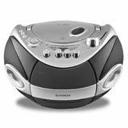
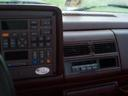
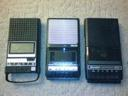
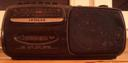
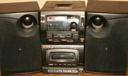

In [18]:
dp.head()

In [19]:
from domino import explore

explore(
    data=dp["img_path", "img", "label", "prob", "target", "scvis", "planespot_prbs"],
    embeddings="scvis",
    pred_probs="prob",
    targets="target",
    slices="planespot_prbs",
) 

FloatSlider(value=0.5, continuous_update=False, description='Slice Inclusion Threshold', max=1.0, readout_form…

Output()